This colab experiment with imputation for missing news when combining news and stock price data

In [ ]:
import joblib
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
plt.rcParams["font.family"] = "Serif"
color = ['chocolate', 'brown', 'darkgreen', 'darkcyan', 'darkkhaki', 'purple']
style.use('seaborn-paper')  # sets the size of the charts
plt.rcParams["font.family"] = "serif"
plt.rcParams['grid.alpha'] = 0.8
plt.rc('grid', linestyle='dotted')
plt.rcParams['figure.dpi'] = 300

In [ ]:
import os
os.chdir('drive/My Drive/TextualSEC/BERT_Edin/buckybuckbuck/ra_gcloud')
!ls

 BERT_unittest.py
 combine.py
 constituents_csv.csv
 constituents_matched.csv
 dea_all.py
 dea_reuters_list.py
 dea_reuters.py
 dea_stock_movement.py
 edinbert.py
 edinbert_unit_cv
'Edin_News_Price_Combination_Imputation (1).ipynb'
 Edin_News_Price_Combination_Imputation.ipynb
 edin_news_price_combination_imputation.py
 graphs
 hist_cons_nan_news.png
 mat.txt
 news-dates.png
 outputs_bert_unittest
 outputs_edinbert
 paw.txt
 plotting.py
 __pycache__
 RA
 ra_data
 raf.txt
 reuters_stock_combined_check_news_0_unittest_1.pkl
 stocks-dates.png


# Load stock and news datasets and examine the date

In [ ]:
# Load stock data and examine the date
df_stock = joblib.load('./ra_data/ch7-reports/stock_movement.pkl')
print('Stock data shape:')
print(df_stock.shape)

Stock data shape:
(6241564, 11)


In [ ]:
stock_set = list(set(df_stock.STOCK))
df_stock.STOCK.describe()

count     6241564
unique       2887
top          CUBE
freq         2369
Name: STOCK, dtype: object

In [ ]:
date_set = list(set(df_stock.DATE))
year_set = [d.year for d in date_set]

In [ ]:
pd.DataFrame(df_stock.DATE).describe()

,DATE
count,6241564
unique,2369
top,2019-05-14 00:00:00
freq,2849
first,2009-12-30 00:00:00
last,2019-05-30 00:00:00


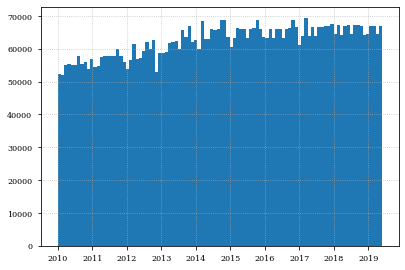

In [ ]:
df_stock['DATE'].hist(bins=100)
plt.savefig('./stocks-dates.png')

In [ ]:
pd.DataFrame(year_set).describe()

,0
count,2369.000000
mean,2014.211904
std,2.726684
min,2009.000000
25%,2012.000000
50%,2014.000000
75%,2017.000000
max,2019.000000


In [ ]:
# Load news data to check dates
df_news = joblib.load('./ra_data/reuters/reuters_combined_check_news_1_unittest_0.pkl')
print(df_news.shape)
print(df_news.columns)

(25198, 3)
Index(['STOCK', 'DATE', 'NEWS'], dtype='object')


In [ ]:
df_news.STOCK.describe()

count     25198
unique      203
top          GS
freq        307
Name: STOCK, dtype: object

In [ ]:
date_set_news = list(set(df_news.DATE))
year_set_news = [d.year for d in date_set_news]

In [ ]:
pd.DataFrame(df_news.DATE).describe()

,DATE
count,25198
unique,324
top,2019-04-23 00:00:00
freq,121
first,2017-11-15 00:00:00
last,2019-05-31 00:00:00


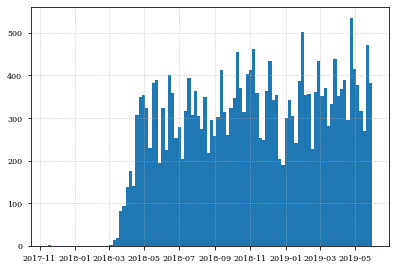

In [ ]:
df_news['DATE'].hist(bins=100)
plt.savefig('./news-dates.png')

In [ ]:
df_news['DATE']

0       2018-12-10
1       2019-04-29
2       2018-11-02
3       2019-01-07
4       2019-03-19
           ...    
25193   2019-01-09
25194   2018-04-20
25195   2018-05-31
25196   2018-08-29
25197   2018-05-15
Name: DATE, Length: 25198, dtype: datetime64[ns]

# AT THIS POINT, it seems the dates of news are plateu from 05-2018 onward, so we decide to combine the two datasets from that month.

In [ ]:
date_pivot = pd.Timestamp(2018, 5, 21)
# Originaly, by using 2018-5-30 (Wed) we had some stocks not having news on that 
# day so we
# moved to one week before as of 2018-05-21 to make sure we have some news to
# impute for the missing value of 5-30. We will remove the redundant date below.

In [ ]:
df_news = df_news[df_news['DATE'] >= date_pivot]
df_news.reset_index(drop=True, inplace=True)

In [ ]:
df_stock = df_stock[df_stock['DATE'] >= date_pivot]
df_stock.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


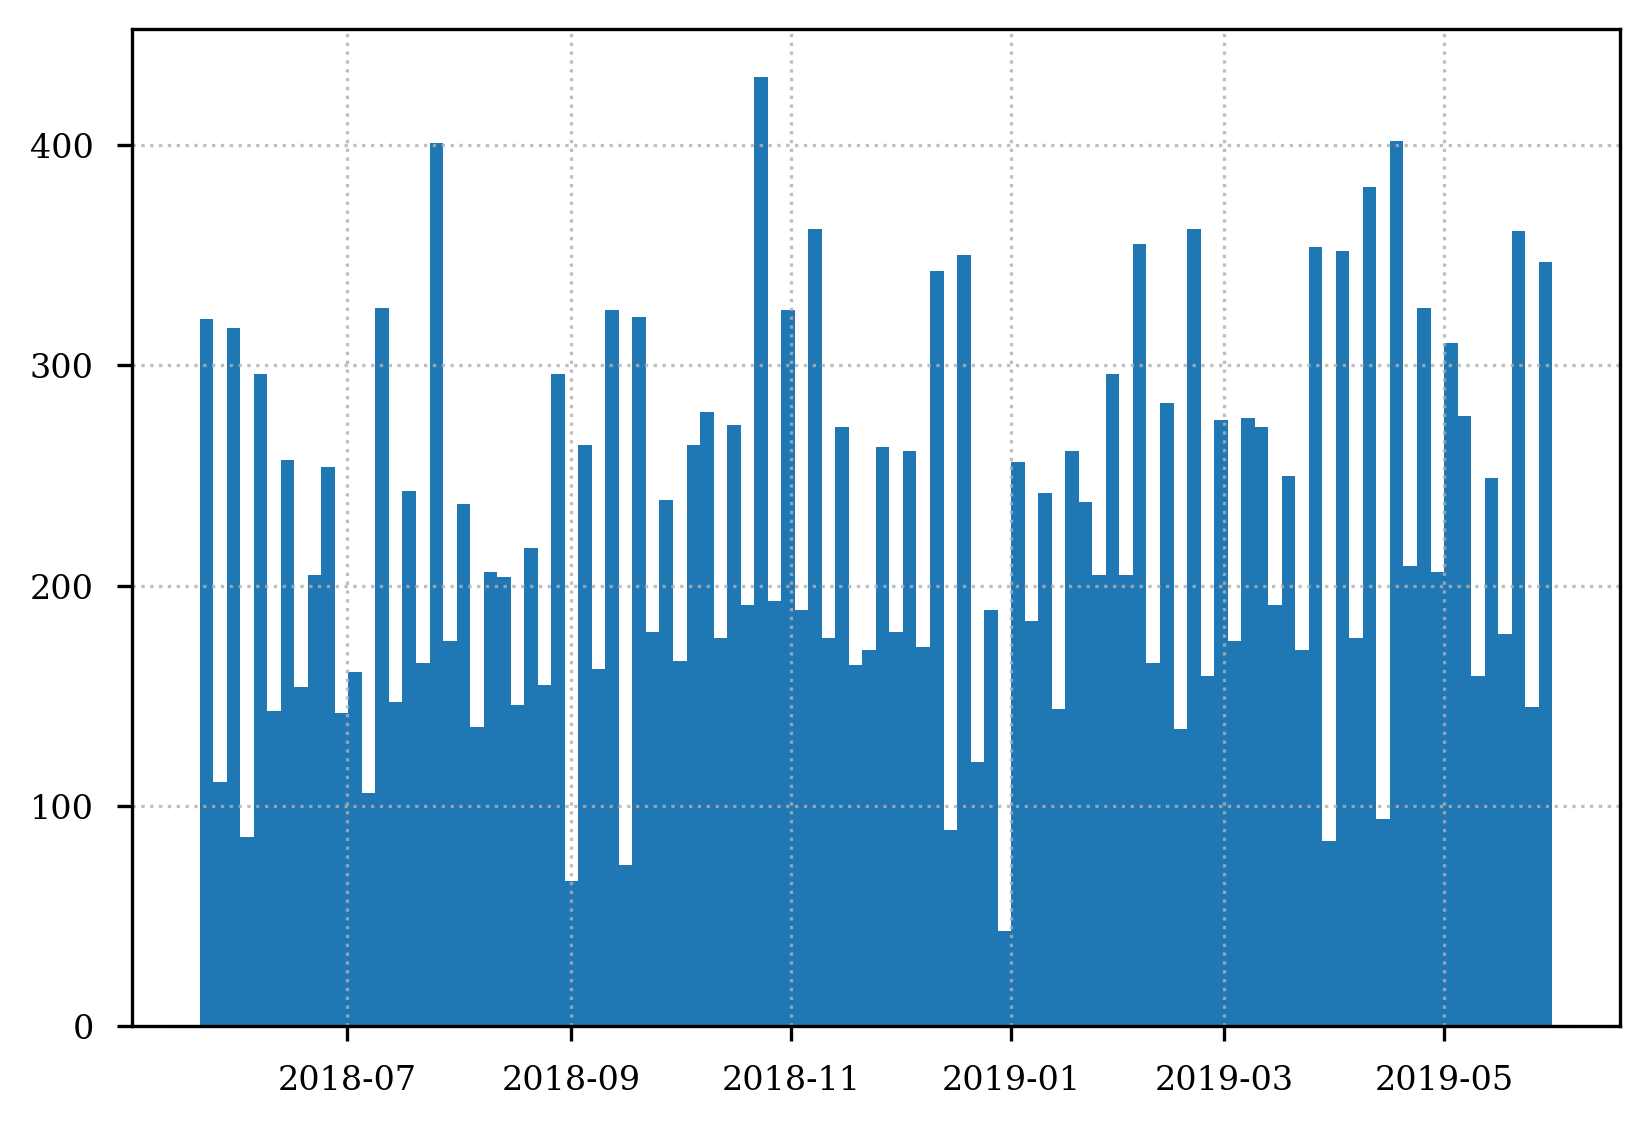

In [ ]:
df_news.DATE.hist(bins=100)


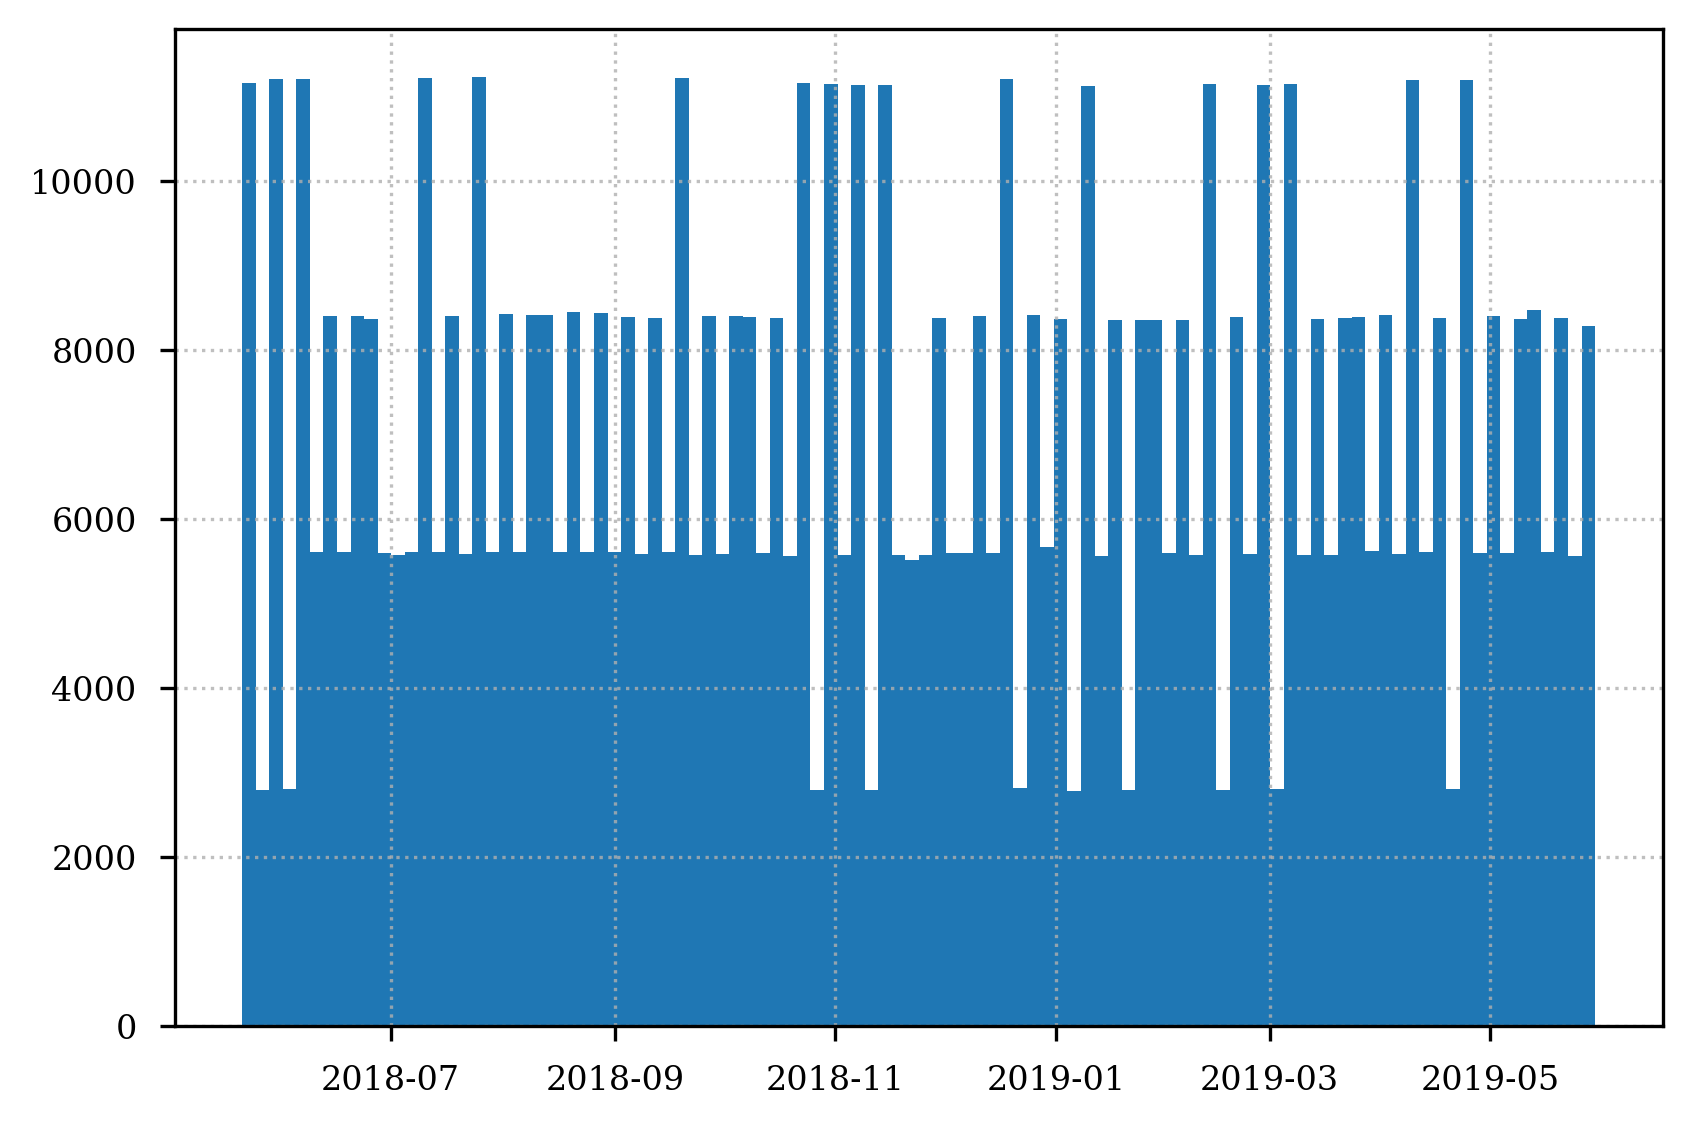

In [ ]:
df_stock.DATE.hist(bins=100)

In [ ]:
df_stock.shape

(721232, 11)

In [ ]:
# Now compare the stock list in news and stock price, filter only those appear in news
stock_list = list(set(df_news.STOCK))
len(stock_list)

203

In [ ]:
df_news.shape

(22588, 3)

In [ ]:
df_news.shape[0]/len(stock_list)  
# That is the average number of dates that have news, for those don't, we will
# impute using the latest news available regardless the number of news in a day

111.27093596059113

In [ ]:
expected_obs = len(stock_list) * 253
expected_obs

51359

In [ ]:
df_stock_filtered = df_stock[df_stock['STOCK'].isin(stock_list)]

In [ ]:
df_stock_filtered.reset_index(drop=True, inplace=True)

In [ ]:
df_stock_filtered.shape

(47214, 11)

In [ ]:
df_stock_filtered.STOCK.describe()

count     47214
unique      183
top          IP
freq        258
Name: STOCK, dtype: object

In [ ]:
# Merge two datasets, using left outer join to keep STOCK-DATE pairs in
# the stock dataset

In [ ]:
final_df = pd.merge(df_stock_filtered, df_news, how='left', on=['STOCK', 'DATE'])

In [ ]:
final_df.shape

(47214, 12)

In [ ]:
final_df

,OPEN,HIGH,LOW,CLOSE,VOLUME,DATE,DIFF,MOVE_UP,MOVE_DOWN,MOVE,STOCK,NEWS
0,97.13,97.650,96.5500,97.21,1466004.0,2018-05-21,-0.80,False,True,True,DG,[Dollar General Launches the Summer of Exclusi...
1,97.50,97.880,96.2900,96.41,1903223.0,2018-05-22,-0.13,False,False,False,DG,NaN
2,96.00,97.120,95.9000,96.28,1602939.0,2018-05-23,0.63,True,False,True,DG,NaN
3,96.34,96.930,95.4417,96.91,2591131.0,2018-05-24,-0.29,False,False,False,DG,NaN
4,97.11,98.605,96.5700,96.62,2029449.0,2018-05-25,-0.38,False,False,False,DG,"[May 25, 2018 Luckily, Zacks Premium customers..."
...,...,...,...,...,...,...,...,...,...,...,...,...
47209,147.98,148.120,145.4600,146.29,1986437.0,2019-05-23,-0.57,False,False,False,ITW,NaN
47210,146.94,147.760,145.4700,145.72,1041437.0,2019-05-24,-3.33,False,True,True,ITW,"[May 25, 2019 Illinois Tool Q1 Earnings Top Es..."
47211,146.70,146.700,142.3100,142.39,3252323.0,2019-05-28,-0.98,False,True,True,ITW,NaN
47212,141.53,142.710,140.3100,141.41,1726352.0,2019-05-29,-0.55,False,False,False,ITW,[Illinois Tool Works decided to bite the bulle...


In [ ]:
# save unimputed data
final_df2 = final_df[final_df.DATE>=pd.Timestamp(2018, 5, 31)].copy()
joblib.dump(final_df2, './ra_data/final_combined_unimputed_stocks_news.pkl')

['./ra_data/final_combined_unimputed_stocks_news.pkl']

In [ ]:
# imputation test
df = pd.DataFrame({'d': [pd.Timestamp(2018, 5, 28),pd.Timestamp(2018, 5, 30),
                         pd.Timestamp(2018, 6, 20),pd.Timestamp(2018, 6, 20),
                         pd.Timestamp(2018, 7, 10),pd.Timestamp(2018, 7, 3),
                         pd.Timestamp(2018, 5, 30),pd.Timestamp(2018, 5, 29)], 
                   's': ['b','b','a','b','c','a','c','b'], 
                   'n':[10,20,np.nan,200,30,np.nan,300,np.nan]})
df['n2'] = df.groupby(['d'])['n'].ffill()
df['n3'] = df.groupby(['d', 's'])['n'].ffill()
print(df)

           d  s      n     n2     n3
0 2018-05-28  b   10.0   10.0   10.0
1 2018-05-30  b   20.0   20.0   20.0
2 2018-06-20  a    NaN    NaN    NaN
3 2018-06-20  b  200.0  200.0  200.0
4 2018-07-10  c   30.0   30.0   30.0
5 2018-07-03  a    NaN    NaN    NaN
6 2018-05-30  c  300.0  300.0  300.0
7 2018-05-29  b    NaN    NaN    NaN


In [ ]:
# find the unique pairs of data-stock
pairs = final_df.groupby(['STOCK','DATE']).size().reset_index().rename(columns={0:'COUNT'})

In [ ]:
if pairs.shape[0] == final_df.shape[0]:
  # already unique pairs
  pairs = None

In [ ]:
final_df.sort_values(by=['STOCK', 'DATE'], inplace=True)

In [ ]:
final_df.reset_index(drop=True, inplace=True)
final_df

,OPEN,HIGH,LOW,CLOSE,VOLUME,DATE,DIFF,MOVE_UP,MOVE_DOWN,MOVE,STOCK,NEWS
0,43.74,44.7939,43.6300,44.28,4930221.0,2018-05-21,-1.40,False,True,True,AAL,[Shares of U.S. airlines have been depressed b...
1,44.50,45.0400,42.8300,42.88,6892448.0,2018-05-22,-0.08,False,False,False,AAL,NaN
2,42.64,42.8700,42.2700,42.80,3915939.0,2018-05-23,0.76,True,False,True,AAL,NaN
3,42.94,43.8900,42.7584,43.56,3855296.0,2018-05-24,1.35,True,False,True,AAL,[Australian airline Qantas Airways QAN.AX said...
4,43.82,45.8200,43.8000,44.91,6517255.0,2018-05-25,-1.32,False,True,True,AAL,[The U.S. Department of Transportation told Co...
...,...,...,...,...,...,...,...,...,...,...,...,...
47209,101.28,101.5750,100.6300,101.39,1134983.0,2019-05-23,-0.40,False,False,False,YUM,[Announces plans to build 600 restaurants in I...
47210,101.81,102.1200,100.9200,100.99,1010773.0,2019-05-24,-1.19,False,True,True,YUM,NaN
47211,101.18,101.8100,99.4100,99.80,3708064.0,2019-05-28,-0.15,False,False,False,YUM,[Now with a crispier crust and more flavorful ...
47212,99.59,99.7400,98.9500,99.65,998486.0,2019-05-29,1.90,True,False,True,YUM,[Wall Street securities analysts revised their...


In [ ]:
final_df.NEWS.isna().sum()/final_df.shape[0]
# Missing degree of combined news and stock price is around 58%

0.572478502139196

In [ ]:
news = final_df.NEWS.copy()
count_cons_nan = []
for i in range(len(news)):
  if news[i] is np.nan:
    k=1
    for j in range(i+1, len(news)):
      if news[j] is np.nan:
        k+=1
      else:
        count_cons_nan.append(k)
        i=j
        break

# Check
len(count_cons_nan)/final_df.shape[0]

0.572478502139196

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
count & 27029 \\
mean  &    13 \\
std   &    35 \\
min   &     1 \\
25\%   &     1 \\
50\%   &     3 \\
75\%   &     7 \\
max   &   257 \\
\bottomrule
\end{tabular}



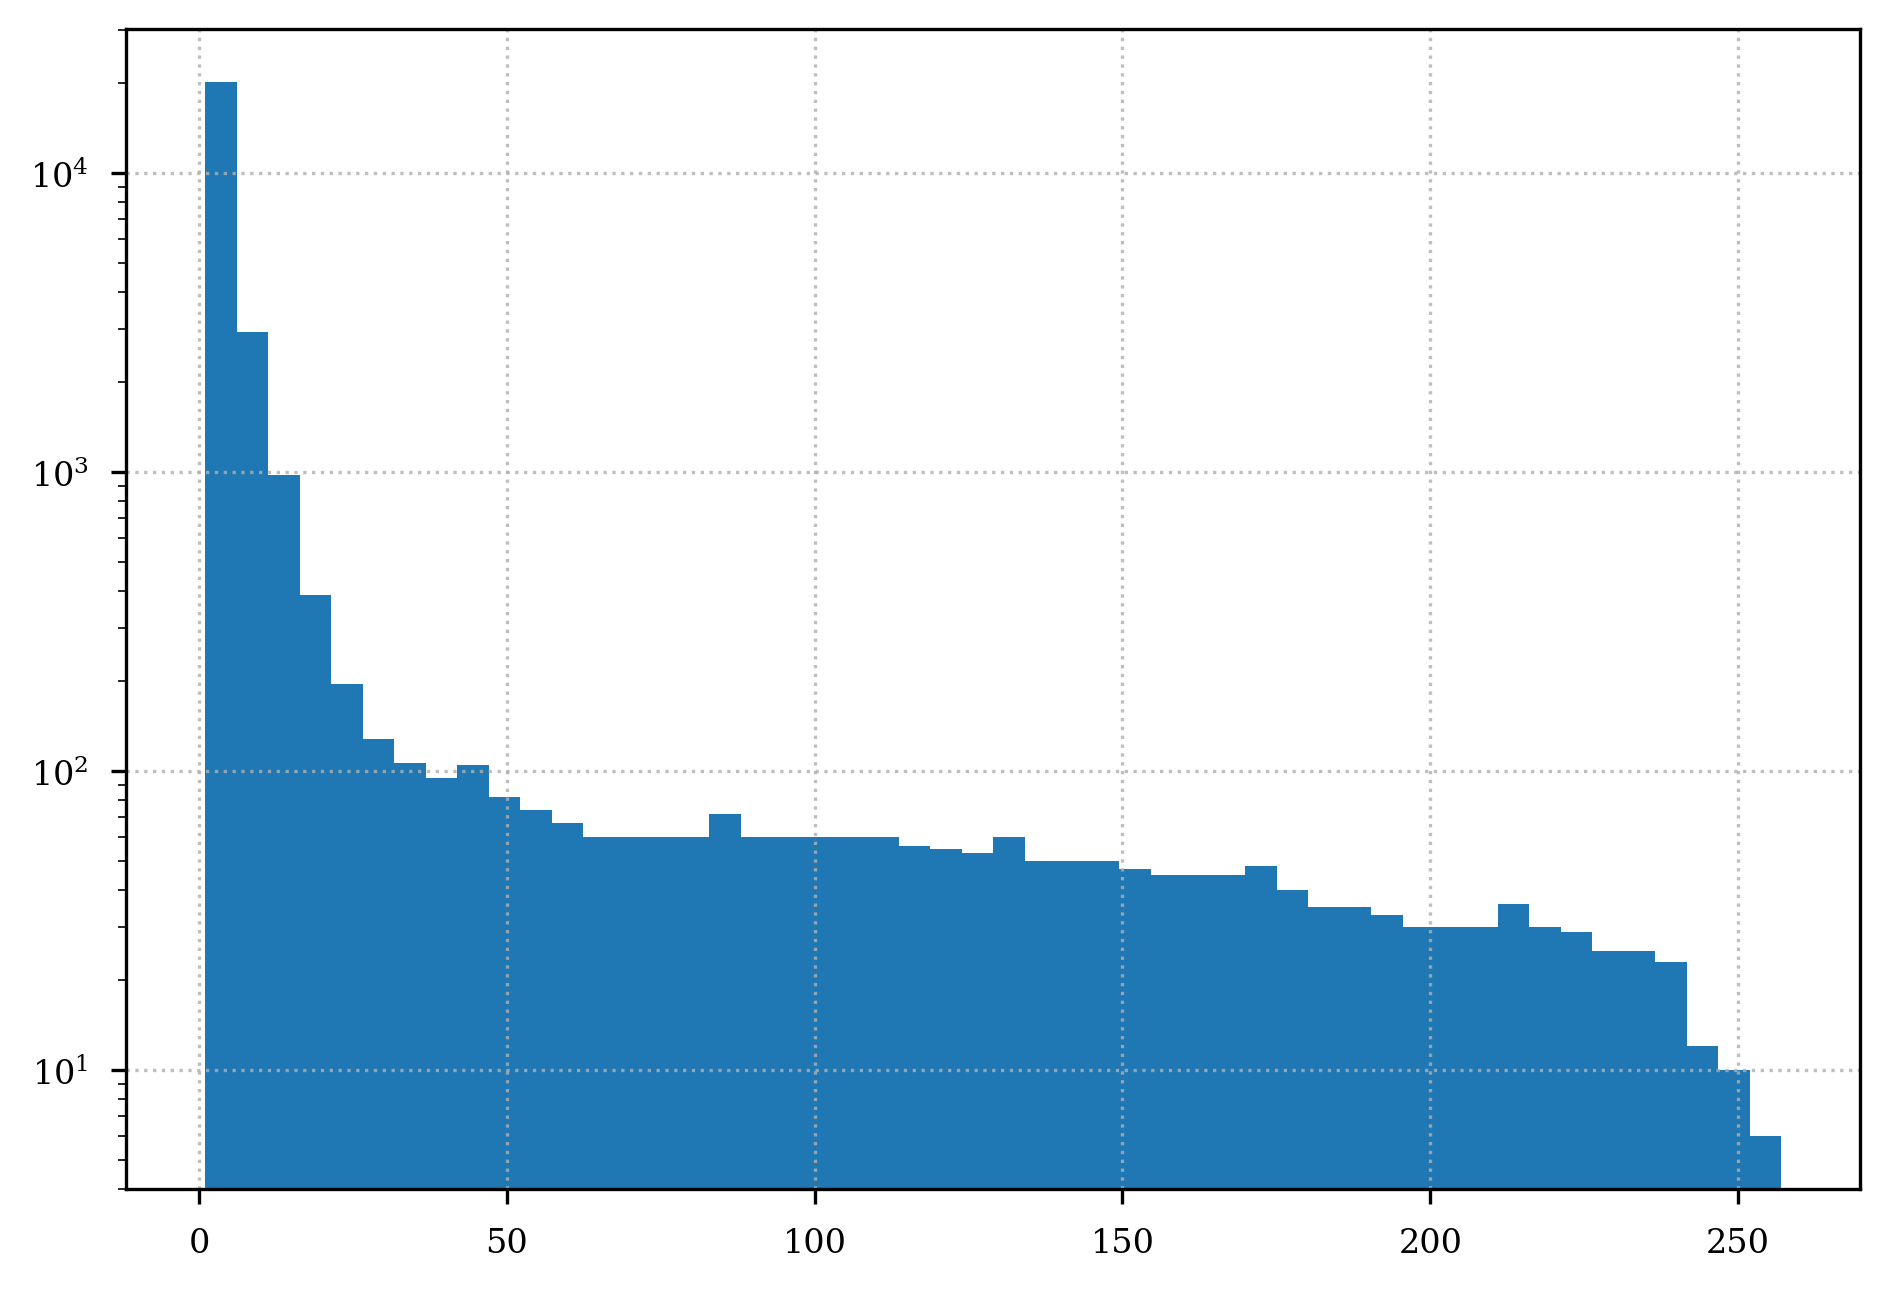

In [ ]:
print(pd.DataFrame(count_cons_nan).describe().to_latex(float_format="%.0f"))

# plot missing frequency
plt.hist(count_cons_nan, bins=50, log=True)
plt.grid()
plt.tight_layout()
plt.savefig('./hist_cons_nan_news.png')

In [ ]:
# create price vector
nor_cols = ['OPEN', 'HIGH', 'LOW', 'VOLUME']
for col in nor_cols:
    new_col = col+'_norm'
    final_df[new_col] = 0
    for i in range(1, final_df.shape[0]):
        final_df.loc[i, new_col] = (final_df[col][i] - final_df[col][i-1])/final_df[col][i-1]
    # shift the price vector
    final_df.loc[:, new_col] = final_df[new_col].shift(1)

In [ ]:
# Now do forward filling for missing NEWS because the STOCK and DATE columns are all sorted
# we fill NA values based on STOCK key
final_df['NEWS_IMPUTED'] = final_df.groupby(['STOCK'])['NEWS'].ffill()

In [ ]:
final_df

,OPEN,HIGH,LOW,CLOSE,VOLUME,DATE,DIFF,MOVE_UP,MOVE_DOWN,MOVE,STOCK,NEWS,OPEN_norm,HIGH_norm,LOW_norm,VOLUME_norm,NEWS_IMPUTED
0,43.74,44.7939,43.6300,44.28,4930221.0,2018-05-21,-1.40,False,True,True,AAL,[Shares of U.S. airlines have been depressed b...,NaN,NaN,NaN,NaN,[Shares of U.S. airlines have been depressed b...
1,44.50,45.0400,42.8300,42.88,6892448.0,2018-05-22,-0.08,False,False,False,AAL,NaN,0.000000,0.000000,0.000000,0.000000,[Shares of U.S. airlines have been depressed b...
2,42.64,42.8700,42.2700,42.80,3915939.0,2018-05-23,0.76,True,False,True,AAL,NaN,0.017375,0.005494,-0.018336,0.398000,[Shares of U.S. airlines have been depressed b...
3,42.94,43.8900,42.7584,43.56,3855296.0,2018-05-24,1.35,True,False,True,AAL,[Australian airline Qantas Airways QAN.AX said...,-0.041798,-0.048179,-0.013075,-0.431851,[Australian airline Qantas Airways QAN.AX said...
4,43.82,45.8200,43.8000,44.91,6517255.0,2018-05-25,-1.32,False,True,True,AAL,[The U.S. Department of Transportation told Co...,0.007036,0.023793,0.011554,-0.015486,[The U.S. Department of Transportation told Co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47209,101.28,101.5750,100.6300,101.39,1134983.0,2019-05-23,-0.40,False,False,False,YUM,[Announces plans to build 600 restaurants in I...,0.005336,-0.002154,0.002475,-0.448576,[Announces plans to build 600 restaurants in I...
47210,101.81,102.1200,100.9200,100.99,1010773.0,2019-05-24,-1.19,False,True,True,YUM,NaN,-0.004521,-0.003483,-0.006418,-0.039318,[Announces plans to build 600 restaurants in I...
47211,101.18,101.8100,99.4100,99.80,3708064.0,2019-05-28,-0.15,False,False,False,YUM,[Now with a crispier crust and more flavorful ...,0.005233,0.005365,0.002882,-0.109438,[Now with a crispier crust and more flavorful ...
47212,99.59,99.7400,98.9500,99.65,998486.0,2019-05-29,1.90,True,False,True,YUM,[Wall Street securities analysts revised their...,-0.006188,-0.003036,-0.014962,2.668543,[Wall Street securities analysts revised their...


In [ ]:
final_df.NEWS_IMPUTED.isna().sum()

2974

In [ ]:
stock_with_missing_news = list(set(final_df[final_df.NEWS_IMPUTED.isna()]['STOCK']))
len(stock_with_missing_news)

116

In [ ]:
df_news[df_news.STOCK==stock_with_missing_news[10]].sort_values(by='DATE')

,STOCK,DATE,NEWS
11008,KIM,2018-05-22,[Kimco Realty Invites You to Join Its Second Q...
10992,KIM,2018-05-28,"[May 28, 2018 Kimco Realty Q1 FFO Beats Estima..."
11026,KIM,2018-06-01,[Kimco Realty Corporation to Present at REITWe...
11002,KIM,2018-06-04,[Kimco Realty Adds to Anchor Lineup at Mill St...
11014,KIM,2018-06-05,"[Jun 05, 2018 Spanning around 620,000-square-f..."
11009,KIM,2018-06-11,[Wall Street securities analysts revised their...
10978,KIM,2018-06-12,"[Jun 12, 2018 However, not all are equally lik..."
10983,KIM,2018-06-18,[Kimco Realty Corporation to Present at Jeffer...
10999,KIM,2018-06-19,[Kimco Realty Releases 2017 Corporate Responsi...
10998,KIM,2018-06-22,[Wall Street securities analysts revised their...


In [ ]:
final_df[final_df.STOCK==stock_with_missing_news[10]].sort_values(by='DATE')

,OPEN,HIGH,LOW,CLOSE,VOLUME,DATE,DIFF,MOVE_UP,MOVE_DOWN,MOVE,STOCK,NEWS,OPEN_norm,HIGH_norm,LOW_norm,VOLUME_norm,NEWS_IMPUTED
28380,14.15,14.6900,13.9600,14.64,5168677.0,2018-05-21,0.46,True,False,True,KIM,NaN,-0.011592,-0.003299,0.002789,-0.035467,NaN
28381,14.63,15.1600,14.6200,15.10,8446798.0,2018-05-22,0.06,False,False,False,KIM,[Kimco Realty Invites You to Join Its Second Q...,-0.563272,-0.553902,-0.568603,0.531117,[Kimco Realty Invites You to Join Its Second Q...
28382,15.10,15.2400,14.9900,15.16,4399324.0,2018-05-23,-0.19,False,True,True,KIM,NaN,0.033922,0.031995,0.047278,0.634228,[Kimco Realty Invites You to Join Its Second Q...
28383,15.16,15.2400,14.8700,14.97,2834357.0,2018-05-24,0.02,False,False,False,KIM,NaN,0.032126,0.005277,0.025308,-0.479173,[Kimco Realty Invites You to Join Its Second Q...
28384,15.04,15.1000,14.8800,14.99,2213304.0,2018-05-25,0.13,True,False,True,KIM,NaN,0.003974,0.000000,-0.008005,-0.355729,[Kimco Realty Invites You to Join Its Second Q...
28385,14.91,15.1950,14.8500,15.12,3131645.0,2018-05-29,0.27,True,False,True,KIM,NaN,-0.007916,-0.009186,0.000672,-0.219116,[Kimco Realty Invites You to Join Its Second Q...
28386,15.11,15.4700,14.8900,15.39,3312269.0,2018-05-30,0.07,False,False,False,KIM,NaN,-0.008644,0.006291,-0.002016,0.414919,[Kimco Realty Invites You to Join Its Second Q...
28387,15.35,15.4700,15.1800,15.46,6266968.0,2018-05-31,-0.07,False,False,False,KIM,NaN,0.013414,0.018098,0.002694,0.057677,[Kimco Realty Invites You to Join Its Second Q...
28388,15.45,15.5900,15.3100,15.39,3092334.0,2018-06-01,0.32,True,False,True,KIM,[Kimco Realty Corporation to Present at REITWe...,0.015884,0.000000,0.019476,0.892047,[Kimco Realty Corporation to Present at REITWe...
28389,15.47,15.7300,15.3600,15.71,4945270.0,2018-06-04,0.25,True,False,True,KIM,[Kimco Realty Adds to Anchor Lineup at Mill St...,0.006515,0.007757,0.008564,-0.506566,[Kimco Realty Adds to Anchor Lineup at Mill St...


In [ ]:
# the above checks return some stocks that do not have news on the week before 
# 2018-5-30
final_df = final_df[final_df.DATE >= pd.Timestamp(2018, 5, 30)]
final_df.shape

(46116, 17)

In [ ]:
final_df.NEWS_IMPUTED.isna().sum()

2566

In [ ]:
stock_with_missing_news = list(set(final_df[final_df.NEWS_IMPUTED.isna()]['STOCK']))
len(stock_with_missing_news)

33

In [ ]:
df_news[df_news.STOCK==stock_with_missing_news[22]].sort_values(by='DATE')

,STOCK,DATE,NEWS
21306,ROK,2019-04-12,[As South Korea?s number one 5G network operat...
21309,ROK,2019-04-16,"[Apr 16, 2019 (Briefing.com via COMTEX News Ne..."
21311,ROK,2019-04-18,"[Apr 18, 2019 (Briefing.com via COMTEX News Ne..."
21301,ROK,2019-04-23,"[Apr 23, 2019 (Briefing.com via COMTEX News Ne..."
21298,ROK,2019-04-24,"[Apr 24, 2019 (Briefing.com via COMTEX News Ne..."
21308,ROK,2019-04-25,"[Apr 25, 2019 (Briefing.com via COMTEX News Ne..."
21304,ROK,2019-04-26,"[Apr 26, 2019 (Briefing.com via COMTEX News Ne..."
21297,ROK,2019-04-29,"[During the visit, IN ships will have professi..."
21314,ROK,2019-05-03,"[May 03, 2019 (Briefing.com via COMTEX News Ne..."
21302,ROK,2019-05-06,"[SEOUL, May 7 (Yonhap) -- The following is the..."


# After imputation for missing NEWS, we filter data again for these 33 missing
# stocks, they are really bad observations as most of them have very low obs
# for news data

In [ ]:
final_df = final_df[~final_df['NEWS_IMPUTED'].isna()]
final_df.shape

(43550, 17)

In [ ]:
final_df.reset_index(drop=True, inplace=True)

In [ ]:
final_df.STOCK.describe()

count     43550
unique      183
top         CAG
freq        252
Name: STOCK, dtype: object

In [ ]:
final_df.DATE.describe()

count                   43550
unique                    252
top       2019-05-30 00:00:00
freq                      183
first     2018-05-30 00:00:00
last      2019-05-30 00:00:00
Name: DATE, dtype: object

In [ ]:
final_df.MOVE.sum()/final_df.shape[0]

0.6587370838117107

In [ ]:
final_df.MOVE_UP.sum()/final_df.shape[0]

0.33864523536165325

In [ ]:
final_df.MOVE_DOWN.sum()/final_df.shape[0]

0.3200918484500574

# Save final data

In [ ]:
# save data
joblib.dump(final_df, './ra_data/final_combined_imputed_stocks_news.pkl')

['./ra_data/final_combined_imputed_stocks_news.pkl']

# Experiment with BERT based on the BERT_unittest.py

In [ ]:
train_raw = joblib.load('./ra_data/final_combined_imputed_stocks_news.pkl')

In [ ]:
train_raw.drop(['NEWS'], axis=1, inplace=True)

In [ ]:
train_raw.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,DATE,DIFF,MOVE_UP,MOVE_DOWN,MOVE,STOCK,NEWS_IMPUTED
0,43.68,43.8250,42.66,43.30,5457878.0,2018-05-30,0.24,True,False,True,AAL,[Citigroup Inc C.N does not plan to use high d...
1,43.40,44.7100,42.97,43.54,8540096.0,2018-05-31,0.46,True,False,True,AAL,[Citigroup Inc C.N does not plan to use high d...
2,44.05,44.0900,43.35,44.00,5472271.0,2018-06-01,0.86,True,False,True,AAL,[IATA says any trade restrictions are bad news...
3,44.04,45.0100,43.96,44.86,5685162.0,2018-06-04,-0.68,False,True,True,AAL,[A hail storm cracked the windshield of an Ame...
4,44.78,45.0213,43.81,44.18,4975326.0,2018-06-05,0.01,False,False,False,AAL,[Airlines use new distribution standard to dri...


In [ ]:
# create new move indicator for move up and move down
train_raw.MOVE.sum()/train_raw.shape[0]

0.6587370838117107

In [ ]:
# if we remove the no move obs, there is around one third of data (34%) will be lost.
# if we retain, there are two choices:
#  1. model with three indicators
#  2. model with move up and move down, but how to proceed with not movement-related
#     yet informative news? One simple strategy is to merge with next news

In [ ]:
## Strategy 1. Remove no-move obs (one day-ahead prediction is not guaranteed, in Cohen+ and Nguyen+ also not mentioned the prediction setup)
## Strategy 2. model with three indicators
## Strategy 3. Merge with next NEWS

In [ ]:
train_raw = train_raw[train_raw.MOVE]
train_raw.reset_index(drop=True, inplace=True)
train_raw.shape

(28688, 12)